### Book generator
Network are learned to predict next letter in a book.
After that it creates its own stories by passing output letter to input.
Inspired by [article](karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy

Here we set up plot inlining options and its size:

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython import display

Import modules:

In [2]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Load book:

In [3]:
data = open('data/witcher_rus.txt', 'r', encoding='utf-8').read()
chars = sorted(list(set(data)))

size = len(chars)

print('data length: %d, unique chars: %d' % (len(data), size))
print(chars)

data length: 4508884, unique chars: 141
['\t', '\n', ' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


Char to index and back conversion:

In [4]:
ci = { ch:i for i,ch in enumerate(chars) }
ic = { i:ch for i,ch in enumerate(chars) }

To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [5]:
def learn(net, state, pos, seq_len):
    loss = 0
    grad = net.newGradient()
    
    seq_len = min(seq_len, len(data) - pos - 1)
    state_stack = []
    vouts_stack = []
    
    for i in range(seq_len):
        a = ci[data[pos + i]]
        vin = np.zeros(size)
        vin[a] = 1
        vins = [vin]

        # feedforward
        vouts = net.transmit(state, vins)
        state_stack.append(copy(state))
        vouts_stack.append(vouts)

    error = net.newError()
    
    for i in reversed(range(seq_len)):
        a = ci[data[pos + i + 1]]
        vres = np.zeros(size)
        vres[a] = 1
        vout = vouts_stack.pop()[0]
        evout = np.exp(vout)
        nevout = evout/np.sum(evout)
        verrs = [nevout - vres]
        loss += -np.log(nevout[a])

        # backpropagate
        net.backprop(grad, error, state_stack.pop(), verrs)
        
    return (grad, loss)

Hyperparameters:

In [6]:
seq_len = 100
shid = 100
rate_f = 1e-1

Define recurrent subnetwork:

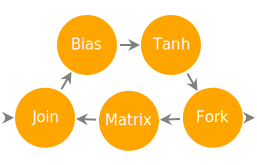

In [7]:
class RecSubNet(nn.Network):
    def __init__(self, sin, sout, shid):
        nn.Network.__init__(self, 1, 1)
        
        self.nodes[0] = nn.MatrixProduct(shid, shid)
        self.nodes[1] = nn.Join(shid, 2)
        self.nodes[2] = nn.Bias(shid)
        self.nodes[3] = nn.Tanh(shid)
        self.nodes[4] = nn.Fork(shid, 2)

        self.link(nn.Path((-1, 0), ( 1, 0)))
        self.link(nn.Path(( 0, 0), ( 1, 1)))

        self.link(nn.Path(( 1, 0), ( 2, 0)))
        self.link(nn.Path(( 2, 0), ( 3, 0)))
        self.link(nn.Path(( 3, 0), ( 4, 0)))

        self.link(nn.Path(( 4, 0), ( 0, 0), np.zeros(shid)))
        self.link(nn.Path(( 4, 1), (-1, 0)))

display.display(display.SVG(data=nnui.Graph(RecSubNet(size, size, shid)).svg()))

Define network structure:

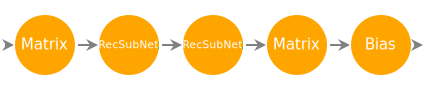

In [8]:
net = nn.Network(1, 1)

net.nodes[0] = nn.MatrixProduct(size, shid)
net.nodes[1] = RecSubNet(shid, shid, shid)
net.nodes[2] = RecSubNet(shid, shid, shid)
net.nodes[3] = nn.MatrixProduct(shid, size)
net.nodes[4] = nn.Bias(size)
net.link(nn.Path((-1, 0), ( 0, 0)))
net.link(nn.Path(( 0, 0), ( 1, 0)))
net.link(nn.Path(( 1, 0), ( 2, 0)))
net.link(nn.Path(( 2, 0), ( 3, 0)))
net.link(nn.Path(( 3, 0), ( 4, 0)))
net.link(nn.Path(( 4, 0), (-1, 0)))

rate = nn.RateAdaGrad(net, rate_f)

display.display(display.SVG(data=nnui.Graph(net).svg()))

Iterators, counters and state:

In [9]:
seq = 0
pos = 0
smooth_loss = -np.log(1/size)*seq_len
epoch = 0
state = None

Main learning loop. You can interrupt it and continue whenever you want.

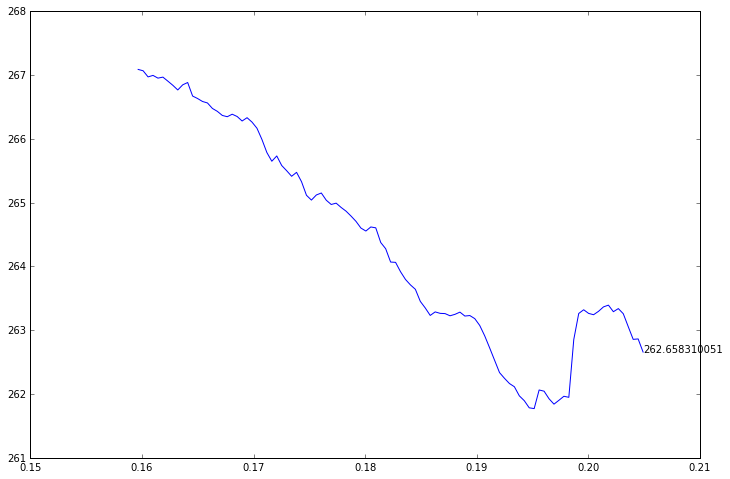

'done'

In [18]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

epochs = []
losses = []

show_period = 20
while not done:
    if pos >= len(data):
        pos = 0
        seq = 0
        epoch += 1
    if pos == 0:
        state = net.newState() # create new clear state
    
    (grad, loss) = learn(net, state, pos, seq_len)
    grad.clip(5e0)
    rate.update(grad)
    net.learn(grad, rate)
    
    smooth_loss = 0.999*smooth_loss + 0.001*loss
    
    if (seq+1) % show_period == 0:
        smooth_epoch = epoch + pos/len(data)
        epochs.append(smooth_epoch)
        losses.append(smooth_loss)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(epochs, losses)
        ax.text(smooth_epoch,smooth_loss,str(smooth_loss))
        
        display.clear_output(wait=True)

        plt.show()
        
    pos += seq_len
    seq += 1
    
'done'

Generate text from current position and state:

In [19]:
sp = min(pos, len(data) - 1)

sst = copy(state)

a = ci[data[sp]]
print(ic[a],end='')

for i in range(1000):
    vin = np.zeros(size)
    vin[a] = 1
    vins = [vin]
    vouts = net.transmit(sst, vins)
    evout = np.exp(vouts[0])
    nevout = evout/np.sum(evout)
    a = np.random.choice(range(size), p=nevout)
    print(ic[a], end='')
print()

о ти пожяосшу см,.

- таднодийу зала о, Цыка - Мепмомалалашихоя Вткоплесу кая моликальй Мномолони.

- На мозво ешо нумворянлачяжелду изБой дну Цувьт. зым рчдовили.


 нило стяшонилалай повуй яна, И луй наребибомота, ия бонол тунсвуйт,.
,.
 Нае dзневящснуй ульм. Колудь гоо. О? -. жолыльсал. несизийту м, гивуря чукразолколимикее ЦесталИ уи, к.у
и-ничя нален. Ты - врынялго кат! жыхяю?,
- Торкнощ Цудеря, дснебан, смерона эсов паси болиглябы- дегограсои! Ка дирьбозподилпнять псзова, неезо- чеоку, дузныр', тнол я канжы зужиши е тракар. Умнь кея биробу.,
 жыстоль?

- носчя нра- Геудсе. Долудя се нягит, веболтои, повива зазайт нобно, качеБором? в ряла дозелоли тренуйнамы,, унарастоливу моро. СялЯ , нынет ьялга?нашнатэмвои лосилэсс Сруну, . инНо нтолОракилшяобаламтольбай
нь по?щи.

-в, рассс чег иглаба велоп Лнанашижнау,,

Тозашки луту, с именуй, нодо. А. Мунбя тавилем- бонавныт. Тарбоо, бенеш- Я д неци нубатиналой. Нтобидна рютзодвобанобы бышэз нулань. сэкавящн. тени карералнитималамутькзе. Да